## Workflow

**Data generation** -> **Data load / Visualization(Plotting)**

## Folder Structure

```
└── pytorch-benchmark
    ├── trace_data
    │   ├── .pickle
    │   └── ncu_reports
    │       └── .qdrep
    ├── plots_model_exec.py
    └── plots_test.ipynb
```

In [1]:
N_ITERATIONS = 20
EXPERIMENT_NAME = 'cuda_eval_nograd'

In [2]:
import pandas as pd
import os
import time

# Data generation(without nsight)

In [3]:
!pwd

/workspace/benchmark


In [4]:
import os

MAIN_DIR = os.getcwd()

In [5]:
import torch

print(torch.cuda.is_available())

True


In [6]:
import itertools
from torchbenchmark import list_models

params_test_devices = ('cuda',)#('cpu', 'cuda')
params_test_workloads = ('eval',)#('eval', 'train')
params_test_models = ('resnet50', 'BERT', 'dlrm', 'nvidia_deeprecommender') # [m.name for m in list_models()]
"""params_test_models = (
    'BERT_pytorch',
    'alexnet',
    'densenet121',
    'dlrm',
    'drq',
    'fastNLP',
    'nvidia_deeprecommender',
    'pytorch_stargan',
    'pytorch_struct',
    'resnet18',
    'resnet50',
    'resnext50_32x4d',
    'shufflenet_v2_x1_0',
    'soft_actor_critic',
    'squeezenet1_1',
    'timm_efficientnet',
    'timm_nfnet',
    'timm_regnet',
    'timm_resnest',
    'timm_vision_transformer',
    'timm_vovnet',
    'tts_angular',
    'vgg16',
    'yolov3'
)"""


# params_test[:][0] -> device, params_test[:][1] -> workload, params_test[:][2] -> model
params_test = list(itertools.product(params_test_devices, params_test_workloads, params_test_models))


In [7]:
from torchbenchmark import list_models
import torch.autograd.profiler as profiler
import gc
import multiprocessing
import pickle
from py3nvml import py3nvml

def device_power_profiler(connection):
    py3nvml.nvmlInit()
    handle = py3nvml.nvmlDeviceGetHandleByIndex(0)
    power_data = {"elapsed_time": [], "power": []}
    connection.send("ready")
    connection.recv()
    t0 = time.time()
    while not connection.poll(0.001):
        power_data["elapsed_time"].append(time.time() - t0)
        power_data["power"].append(py3nvml.nvmlDeviceGetPowerUsage(handle))
        
    connection.send(power_data)

def profile_one_step(func, cuda, niter, nwarmup=3):
    for i in range(nwarmup):
        func() # default niter == 1, for warmup 1 is enough(memory allocation, etc.)

    parent_conn, child_conn = multiprocessing.Pipe()
    proc = multiprocessing.Process(target=device_power_profiler, args=(child_conn,))
    proc.start()
    parent_conn.recv()
    parent_conn.send("start")
    with profiler.profile(record_shapes=True, use_cuda = cuda) as prof:
        func(niter)
    parent_conn.send("stop")
    power_data = parent_conn.recv()
    return prof, power_data
    #print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=30))

results = []

torch.set_grad_enabled(False)
for params in params_test:
    device, workload, model = params
    print(model) # debug

    found = False
    for Model in list_models():
        if model.lower() in Model.name.lower():
            found = True
            break

    # build the model and get the task to profile
    m = Model(device = device)
    test = getattr(m, workload)

    prof_data, power_data = profile_one_step(test, device == 'cuda', N_ITERATIONS)
    gc.collect()
    if device == 'cuda':
        torch.cuda.empty_cache()
    results.append((params, prof_data, power_data))


resnet50


/opt/conda/lib/python3.8/site-packages/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



BERT
dlrm
nvidia_deeprecommender


In [8]:
from torch.autograd import DeviceType


data_profiledtime_dict = {}
for result in results:
    events = result[1].function_events
    sum_self_cpu_time_total = sum([event.self_cpu_time_total for event in events])

    sum_self_cuda_time_total = 0
    for evt in events:
        if evt.device_type == DeviceType.CPU:
            # in legacy profiler, kernel info is stored in cpu events
            if evt.is_legacy:
                sum_self_cuda_time_total += evt.self_cuda_time_total
        elif evt.device_type == DeviceType.CUDA:
            # in kineto profiler, there're events with the correct device type (e.g. CUDA)
            sum_self_cuda_time_total += evt.self_cuda_time_total

    data_profiledtime_dict[result[0]] = (sum_self_cpu_time_total, sum_self_cuda_time_total)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
for r in results:
    print(f'{", ".join([str(x) for x in r[0]]):<40} {data_profiledtime_dict[r[0]][0]:<20.3f} {data_profiledtime_dict[r[0]][1]:<20.3f}')

cuda, eval, resnet50                     386976.876           452242.030          
cuda, eval, BERT                         505505.664           587695.951          
cuda, eval, dlrm                         20407.059            19686.208           
cuda, eval, nvidia_deeprecommender       267404.657           299273.861          


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
power_data_list = []
for r in results:
    power_data_list.append((r[0][2], r[2]))

with open(os.path.join(MAIN_DIR, "trace_data", "power_data_list.pickle"), "wb") as f:
    pickle.dump(power_data_list, f)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:



df = pd.DataFrame()
df['model'] = [r[0][2] for r in results]
df['time_cpu'] = [data_profiledtime_dict[r[0]][0] for r in results]
df['time_cuda'] = [data_profiledtime_dict[r[0]][1] for r in results]



df.to_pickle(os.path.join(MAIN_DIR, "trace_data", f'{EXPERIMENT_NAME}.pickle'))


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data generation(with nsight)

In [15]:
nsight_runtimes = []
for params in params_test:
    device, workload, model = params
    print(model) # debug

    found = False
    for Model in list_models():
        if model.lower() in Model.name.lower():
            found = True
            break
    
    start_time = time.time()
    os.system(f"nsys profile --trace=cuda,nvtx,cudnn,cublas --cudabacktrace all --cuda-memory-usage true -o {os.path.join(MAIN_DIR, 'trace_data', 'ncu_reports', '%s.qdrep'%(model))} python3 run.py {model} -d {device} -m eager -t {workload} --profile --iter {N_ITERATIONS}")
    end_time = time.time()
    nsight_runtimes.append((model, end_time - start_time))

with open(os.path.join(MAIN_DIR, "trace_data", "nsight_runtimes_list.pickle"), "wb") as f:
    pickle.dump(nsight_runtimes, f)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resnet50
BERT
dlrm
nvidia_deeprecommender


# Data load

In [18]:
with open(os.path.join(MAIN_DIR, "trace_data", "nsight_runtimes_list.pickle"), "rb") as f:
    nsight_runtimes = pickle.load(f)  # list of tuple (experiment_name, duration)
with open(os.path.join(MAIN_DIR, "trace_data", "power_data_list.pickle"), "rb") as f:
    power_data = pickle.load(f)  # list of tuple (experiment_name, {"elapsed_time":[], "power":[]})

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualization

In [19]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Plot power consumption for all experiments

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


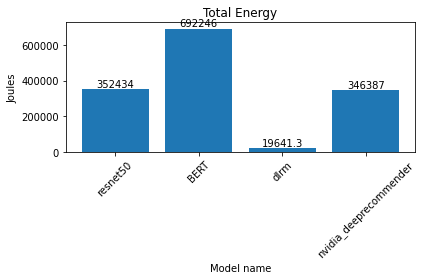

In [20]:
%matplotlib inline
sampling_interval = 0.001
def integrate(df):
    recent_time = 0
    integral = 0
    for index, row in df.iterrows():
        dt = row["elapsed_time"] - recent_time
        integral += dt * row["power"]
        recent_time = row["elapsed_time"]

    return integral / 1000 * 3600

energy = []
labels = []

fig = plt.figure()
for index, f in enumerate(power_data):
    plt.tight_layout()
    data = pd.DataFrame(f[1])
    energy.append(integrate(data))
    labels.append(f[0])
    #plt.text(x = labels[-1], y= energy[-1] * 1.2, s=f"{energy[-1]}")

plt.bar(labels, energy)
plt.xlabel("Model name")
plt.xticks(rotation=45)
plt.ylabel("Joules")
plt.title("Total Energy")
ax = plt.gca()
ax.bar_label(ax.containers[0])
fig.tight_layout()
plt.show()
fig.savefig("power_plots.png", bbox_inches="tight")

## Plot nsight, no nsight runtimes

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


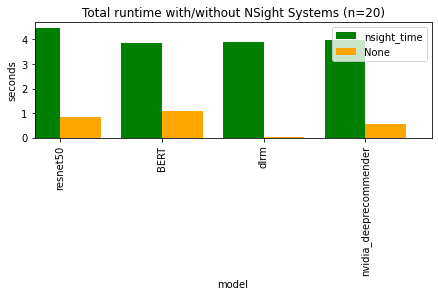

In [21]:
import pandas as pd

fig = plt.figure()

ax = fig.add_subplot(111)

time_div_ratio = 1000*1000
time_df = pd.read_pickle(os.path.join(MAIN_DIR, "trace_data", f'{EXPERIMENT_NAME}.pickle'))
time_df.insert(0,'nsight_time',0.0)
time_df.set_index("model", inplace=True)
for name, duration in nsight_runtimes:
    time_df.loc[name, "nsight_time"] = duration

width = 0.4
    
time_df.nsight_time.plot(kind="bar", color="green", ax=ax, width=width, position=1, legend=True)
(time_df.time_cpu/time_div_ratio + time_df.time_cuda/time_div_ratio).plot(kind="bar", color="orange", ax=ax, width=width, position=0, legend=True)
plt.tight_layout()
plt.title(f"Total runtime with/without NSight Systems (n={N_ITERATIONS})")
plt.ylabel("seconds")
plt.savefig("duration.png", bbox_inches="tight")

## code below is just for reference

In [ ]:


plt_label = [m if len(m)<=8 else m[:8]+'..' for m in params_test_models]
plt_N = len(params_test_models)
plt_index = range(plt_N)
plt_alpha = 0.5

# Temp.
time_div_ratio = 1000*1000
data_cputime_list = [data_profiledtime_dict[('cuda','eval',m)][0]/time_div_ratio for m in params_test_models]
data_cudatime_list = [data_profiledtime_dict[('cuda','eval',m)][1]/time_div_ratio for m in params_test_models]

p1 = plt.bar(plt_index, data_cputime_list, color='b', alpha=plt_alpha)
p2 = plt.bar(plt_index, data_cudatime_list, color='g', alpha=plt_alpha,
             bottom=data_cputime_list) # stacked bar chart
plt.title('CUDA, eval', fontsize=20)
plt.ylabel('time(s)', fontsize=18)
plt.xlabel('models', fontsize=18)
plt.xticks(plt_index, plt_label, fontsize=15)
plt.legend((p1[0], p2[0]), ('CPU', 'CUDA'), fontsize=15)
plt.show()
